In [6]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import time
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("white")

pandas2ri.activate()

In [7]:
data_file = "data/data_CHT_SIMPA.txt"
basin_file = "data/basins_CHT.txt"
# data_file = "data/data_CHG_SIMPA.txt"
# basin_file = "data/basins_CHG.txt"

In [8]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('exec_optim_semidist.R')

# Loading the function we have defined in R.
robjects.globalenv['init_global'](data_file, basin_file)
exec_function_r = robjects.globalenv['eval_basin_param']
get_basin_q = robjects.globalenv['get_basin_q']

Rows: 1 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): code, order, codedown, supha



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
# result_path = "results/new_data/"
result_path = ""
# problem_type = "semidist_5043"
problem_type = "cascade_5043"
exec_types = [("KGE", 1)]

result_files = [
    (f"./{result_path}config_{problem_type}_{model}_{metric}.csv", model, metric)
    for metric, model in exec_types
]

# result_files = [
#     (f"./{result_path}config_{problem_type}_0_MSE.csv",0,"MSE"),
#     (f"./{result_path}config_{problem_type}_1_MSE.csv",1,"MSE"),
#     (f"./{result_path}config_{problem_type}_2_MSE.csv",2,"MSE"),
#     (f"./{result_path}config_{problem_type}_3_MSE.csv",3,"MSE"),
#     (f"./{result_path}config_{problem_type}_0_NSE.csv",0,"NSE"),
#     (f"./{result_path}config_{problem_type}_1_NSE.csv",1,"NSE"),
#     (f"./{result_path}config_{problem_type}_2_NSE.csv",2,"NSE"),
#     (f"./{result_path}config_{problem_type}_3_NSE.csv",3,"NSE"),
#     (f"./{result_path}config_{problem_type}_0_KGE.csv",0,"KGE"),
#     (f"./{result_path}config_{problem_type}_1_KGE.csv",1,"KGE"),
#     (f"./{result_path}config_{problem_type}_2_KGE.csv",2,"KGE"),
#     (f"./{result_path}config_{problem_type}_3_KGE.csv",3,"KGE"),
# ]

for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if not os.path.exists(file_name):
        raise Exception("Some files were not found.")

./config_cascade_5043_1_KGE.csv Yes


In [11]:
agg_q = {}
result_q = {}

basin_df = pd.read_csv("data/CHGbasins.txt")
basin_df.sort_values(by=["order"])

eval_df = pd.DataFrame(columns=["model", "target", "basin_idx", "MSE", "RMSE", "Pbias", "NSE", "R2", "KGE", "params"])

for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if os.path.exists(file_name):
        params = np.loadtxt(file_name, delimiter=",")

        prev_q = 0
        agg_q = {}
        basin_params = {}
        for idx in basin_df.index:
            basin_code = basin_df["code"][idx]
            codedown = basin_df["codedown"][idx]
            
            prev_q = 0
            if basin_code in agg_q:
                prev_q = agg_q[basin_code]
            
            if codedown not in agg_q:
                agg_q[codedown] = 0
            
            agg_q[codedown] += get_basin_q(model, params[idx], basin_code, prev_q)
            print(agg_q)
            metrics = exec_function_r(model, params[idx], basin_code, prev_q)
            # eval_df.loc[len(eval_df)] = [model, target, basin_code] + list(metrics) + ["[" + ";".join(map(str, params[idx])) + "]"]

            param_str = np.array2string(params[idx], max_line_width=np.inf, separator=";").replace(" ", "")
            eval_df.loc[len(eval_df)] = [model, target, basin_code] + list(metrics) + [param_str]

eval_df = eval_df[eval_df["target"] != "R2"]
eval_df

./config_cascade_5043_1_KGE.csv Yes
{5043: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan,

R[write to console]: Error in if (sd.obs > 0) { : valor ausente donde TRUE/FALSE es necesario



RRuntimeError: Error in if (sd.obs > 0) { : valor ausente donde TRUE/FALSE es necesario


In [ ]:
eval_df.to_csv(f"{problem_type}_table.txt", index=False, quoting=csv.QUOTE_NONE)

In [ ]:
eval_df[eval_df["basin_idx"] == 5043]

,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE,params
4,0,MSE,5043,122.422475,11.064469,-2.9,0.318758,0.499021,0.678171,[9.85793748e-01;1.00963347e+03;1.00000000e+00;...
9,1,MSE,5043,123.388311,11.108029,-3.3,0.313384,0.486659,0.676280,[9.71361815e-01;8.89040434e+02;9.99025328e-01;...
14,2,MSE,5043,133.391963,11.549544,-6.0,0.257717,0.447842,0.650580,[9.82519309e-01;2.00000000e+03;0.00000000e+00;...
19,3,MSE,5043,114.696501,10.709645,-3.2,0.361751,0.498075,0.695464,[9.87180849e-01;1.15016524e+03;1.00000000e+00;...
24,0,NSE,5043,110.792203,10.525788,-3.4,0.383477,0.500588,0.702062,[9.88518364e-01;1.27211573e+03;1.00000000e+00;...
29,1,NSE,5043,118.898226,10.904046,-2.0,0.338370,0.487340,0.686298,[9.41276416e-01;8.94633329e+02;9.99997515e-01;...
34,2,NSE,5043,121.130214,11.005917,-1.2,0.325949,0.471428,0.679171,[9.67304413e-01;1.91984283e+03;9.99868323e-01;...
39,3,NSE,5043,116.548302,10.795754,-2.5,0.351446,0.477585,0.686952,[9.90160590e-01;1.85650189e+03;1.00000000e+00;...
44,0,KGE,5043,129.494060,11.379546,-2.1,0.279407,0.479550,0.662008,[9.88686276e-01;1.24357954e+03;9.99999696e-01;...
49,1,KGE,5043,143.945514,11.997730,-1.4,0.198990,0.445079,0.629225,[9.87204091e-01;1.08388601e+03;9.98877482e-01;...


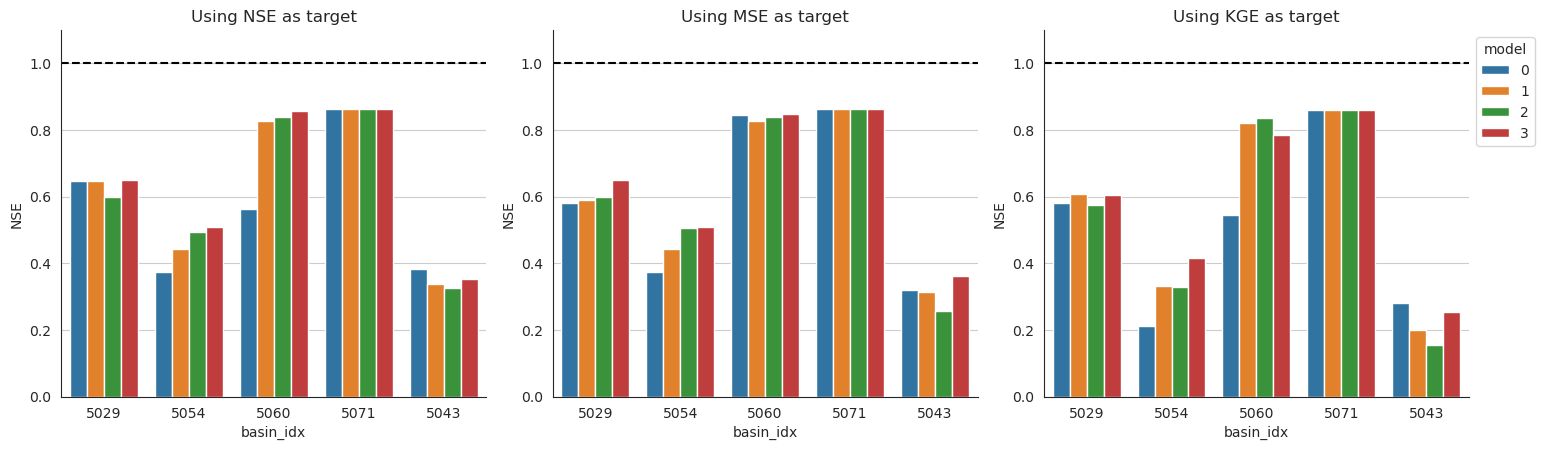

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15, 5))


metric_measure = "NSE"
for idx, metric in enumerate(["NSE", "MSE", "KGE"]):
    ax = axes[idx]

    fig.tight_layout(h_pad=2)
    plt.subplots_adjust(top=0.85)

    data_to_plot = eval_df[eval_df["target"] == metric][['basin_idx', 'model', metric_measure]]
    hist_ax = sns.barplot(data=data_to_plot, x="basin_idx", y=metric_measure, hue="model", ax=ax, order=basin_df["code"])
    hist_ax.set(title = f"Using {metric} as target")


    if idx == 2:
        sns.move_legend(hist_ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        hist_ax.get_legend().remove()
    

    if metric_measure not in ["MSE", "RMSE", "Pbias"]:
        ax.axhline(1, color="k", linestyle="--")
        if metric == "R2" and metric_measure in ["NSE", "KGE"]:
            hist_ax.set(ylim = [-0.5, 1.1])
            ax.axhline(0, color="k")
        else:
            hist_ax.set(ylim = [0, 1.1])
    

    if metric_measure == "Pbias":
        hist_ax.set(ylim = [-27, 27], yticks = range(-25,30,5))
        ax.axhline(0, color="k")
    
    sns.despine()
    ax.grid(axis="y")

plt.show()